Diego Toribio <br>
Professor Sam Keene <br>
Frequentist Machine Learning <br>
Project 4: Gradient Boosted Trees

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from matplotlib import transforms
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## California Housing Dataset

### Load Dataset

In [ ]:
# Loading Dataset
ch = fetch_california_housing(as_frame=True)
X1, y1 = ch.data, ch.target

print(f"X Shape: {X1.shape}")
print(f"y Shape: {y1.shape}")
print("Features:", list(X1.columns))

# Data Split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=13)

X Shape: (20640, 8)
y Shape: (20640,)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


### Model

In [ ]:
# Initialize Model
model = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=1)

# Perform Grid Search
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [500, 1000, 1500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X1_train, y1_train)

# Store best parameters
bp_ch = grid_search.best_params_
bs_ch = grid_search.best_score_

print(f"Best score: {-bs_ch:.3f} (MSE)")
print(f"Best parameters: {bp_ch}")

Best score: 0.200 (MSE)
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1500, 'subsample': 1.0}


### Training and Test Absolute Error

*Figure 10.13* , Average-absolute error as a function of number of iterations for the California housing data.

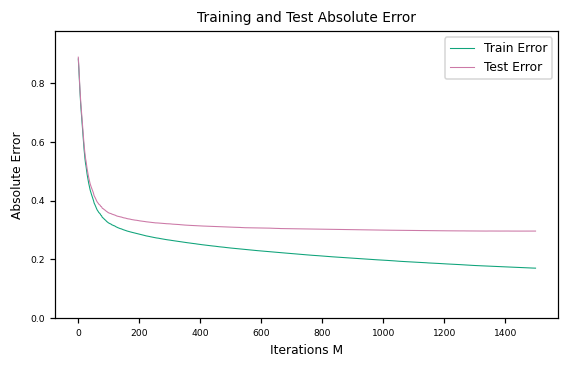

In [ ]:

bm_ch = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=1,
    colsample_bytree=bp_ch['colsample_bytree'],
    learning_rate=bp_ch['learning_rate'],
    max_depth=bp_ch['max_depth'],
    n_estimators=bp_ch['n_estimators'],
    subsample=bp_ch['subsample'],
    eval_metric='mae'
)

eval_set = [(X1_train, y1_train), (X1_test, y1_test)]
bm_ch.fit(X1_train, y1_train, eval_set=eval_set, verbose=False)

results1 = bm_ch.evals_result()
train1_error = results1['validation_0']['mae']
test1_error = results1['validation_1']['mae']

def plot_loss_graph(train_error, test_error, xlabel='Iterations M', ylabel='Absolute Error', title='Training and Test Absolute Error'):
    x_axis = range(len(train_error))
    fig, ax = plt.subplots(figsize=(5.9, 3.39), dpi=110)
    ax.plot(x_axis, train_error, label='Train Error', color='#10A47B', linewidth=0.7)
    ax.plot(x_axis, test_error, label='Test Error', color='#CC79A7', linewidth=0.7)
    ax.set_xlabel(xlabel, fontsize=8)
    ax.set_ylabel(ylabel, fontsize=8)
    ax.set_ylim(0, max(max(train_error), max(test_error)) * 1.1)
    ax.set_title(title, fontsize=9)

    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(6)

    _ = ax.legend(loc='upper right', prop={'size': 8})

    plt.show()

plot_loss_graph(train1_error, test1_error)

### Relative Importance of Predictors

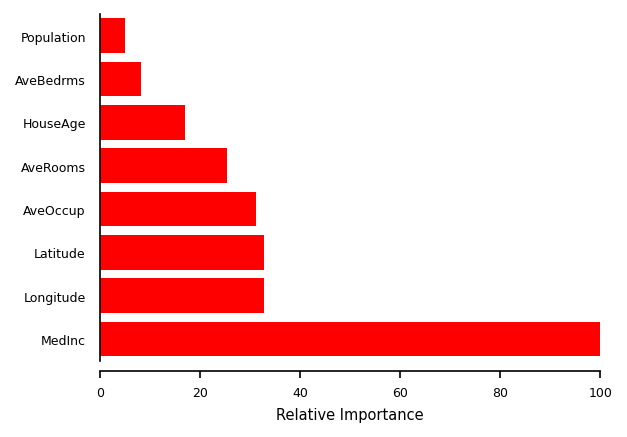

In [ ]:
def plot_feature_importances(model, X):
    importance = model.feature_importances_
    features = X.columns

    max_importance = np.max(importance)
    relative_importance = sorted(zip(100 * importance / max_importance, features),
                                 key=lambda x: x[0], reverse=True)

    yticks = np.arange(len(relative_importance))
    yticklabels = [ri[1] for ri in relative_importance]
    bars_sizes = [ri[0] for ri in relative_importance]

    fig, ax = plt.subplots(figsize=(4.3, 3), dpi=150)
    bars = ax.barh(yticks, bars_sizes, height=0.8, color='red')
    plt.setp(ax, yticks=yticks, yticklabels=yticklabels)
    ax.set_xlim([0, 100])
    ax.set_ylim([-0.5, len(relative_importance) - 0.5])
    for e in ax.get_yticklabels() + ax.get_xticklabels():
        e.set_fontsize(6)
    ax.tick_params(left=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    offset = transforms.ScaledTranslation(0, -0.07, fig.dpi_scale_trans)
    for e in ax.get_xticklabels() + ax.xaxis.get_ticklines() + [ax.spines['bottom']]:
        e.set_transform(e.get_transform() + offset)
    ax.spines['bottom'].set_bounds(0, 100)
    _ = ax.set_xlabel('Relative Importance', fontsize=7)
    plt.show()


plot_feature_importances(bm_ch, X1_train)

#### Discussion


&nbsp;&nbsp;&nbsp;&nbsp; The **Relative Importance Plot** shows the relative variable importances for each of the eight predictor variables. The plot ranks the Median Income (`MedInc`) as the most influential predictor, followed by the geographic coordinates (`Latitude & Longitude`).

&nbsp;&nbsp;&nbsp;&nbsp;The fact that MedInc holds a relative importance score of 100, compared to 30 for both Latitude and Longitude,  highlights that median income has a substantially stronger predictive power for housing prices than geographical. This observation is reasonable as areas with higher median incomes generally correlate with higher property values.


&nbsp;&nbsp;&nbsp;&nbsp; Interestingly, the Average Bedrooms (`AveBedrooms`) was one of the least significant predictors. This is suprising as one might assume that a greater number of bedrooms typically indicative of larger properties, would correspond to higher property values.

### Partial Dependance

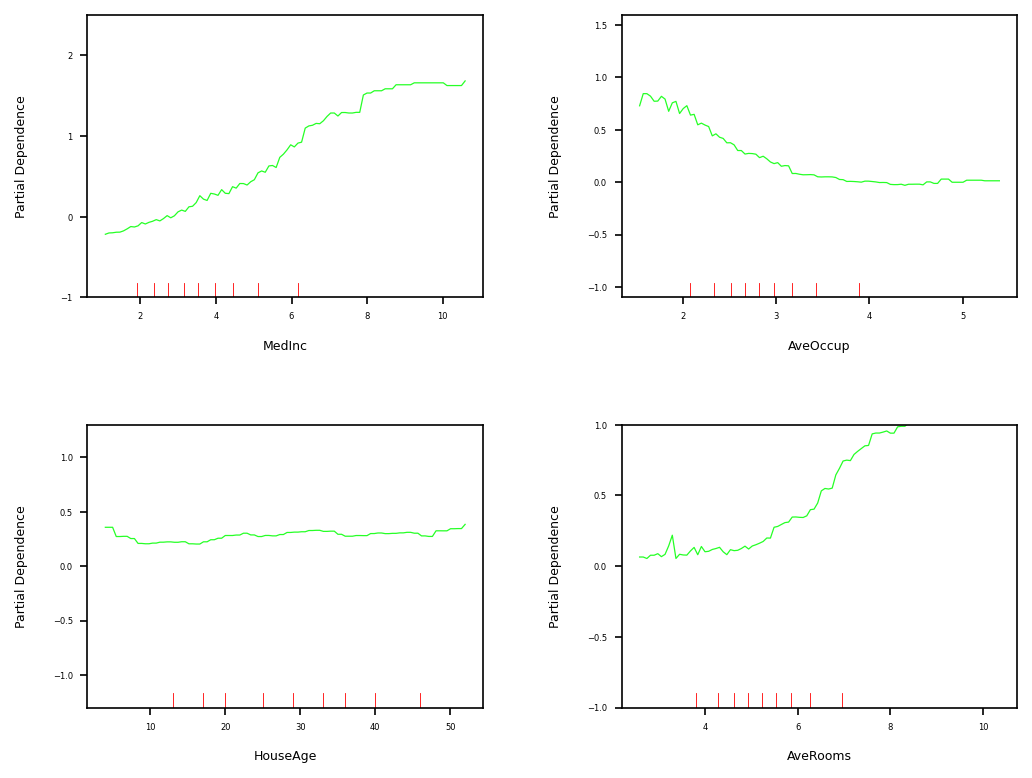

In [ ]:
def plot_partial_dependence(model, X, y, feature, ax, y_lim):
    feature_col = X[feature]
    vals = np.linspace(np.percentile(feature_col, 1), np.percentile(feature_col, 99), 100)
    y1_median = np.median(y)
    results = []
    for val in vals:
        X_tmp = X.copy()
        X_tmp[feature] = val
        preds = model.predict(X_tmp)
        results.append(np.mean(preds) - y1_median)

    ax.plot(vals, results, linewidth=0.6, color='#26FF26')
    ax.set_xlabel(feature, fontsize=6)
    ax.set_ylabel('Partial Dependence', fontsize=6)
    ax.set_ylim(y_lim)

    # Adding red lines at deciles
    deciles = np.percentile(feature_col, np.linspace(10, 90, 9))
    y_from, y_to = y_lim
    for decile in deciles:
        ax.plot([decile, decile], [y_from, y_from + (y_to - y_from) * 0.05], color='red', linewidth=0.4)

    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(4)
    ax.yaxis.set_label_coords(-0.15, 0.5)
    ax.xaxis.set_label_coords(0.5, -0.15)

fig, axarr = plt.subplots(2, 2, figsize=(8, 6), dpi=150)
plt.subplots_adjust(wspace=0.35, hspace=0.45)

plot_partial_dependence(bm_ch, X1, y1, 'MedInc', axarr[0, 0], (-1, 2.5))
plot_partial_dependence(bm_ch, X1, y1, 'AveOccup', axarr[0, 1], (-1.1, 1.6))
plot_partial_dependence(bm_ch, X1, y1, 'HouseAge', axarr[1, 0], (-1.3, 1.3))
plot_partial_dependence(bm_ch, X1, y1, 'AveRooms', axarr[1, 1], (-1, 1))

plt.show()

### Two Variable Partial Dependence

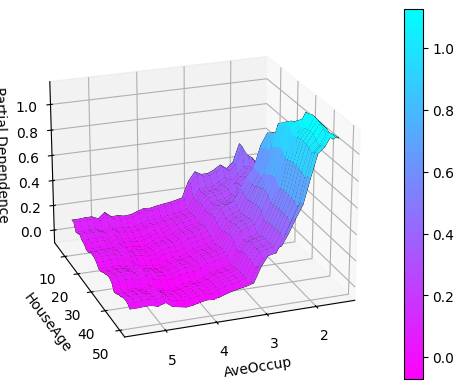

In [ ]:
def plot_two_variable_partial_dependence(model, X, y, feature1, feature2):
    N = 256
    vals = np.ones((N, 4))
    vals[:, 0] = np.linspace(1, 0, N)
    vals[:, 1] = np.linspace(0, 1, N)
    vals[:, 2] = np.linspace(1, 1, N)
    newcmp = ListedColormap(vals)

    vals1 = np.linspace(1.5, 5.5, 30)
    vals2 = np.linspace(5, 50, 30)
    N1, N2 = np.meshgrid(vals1, vals2)
    Y = np.zeros(shape=N1.shape)

    y_overall_median = np.median(y)

    for i in range(N1.shape[0]):
        for j in range(N1.shape[1]):
            X_tmp = X.copy()
            X_tmp[feature1] = N1[i, j]
            X_tmp[feature2] = N2[i, j]
            Y[i, j] = np.mean(model.predict(X_tmp)) - y_overall_median

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(N1, N2, Y, color='black', linewidth=0.5)
    surf = ax.plot_surface(N1, N2, Y, cmap=newcmp, shade=False)
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.set_zlabel('Partial Dependence')
    plt.colorbar(surf)
    ax.view_init(22, 70)
    plt.show()

plot_two_variable_partial_dependence(bm_ch, X1, y1, 'AveOccup', 'HouseAge')

### Stretch Goal: SHAP

In [ ]:
explainer1 = shap.Explainer(bm_ch)
shap_values1 = explainer1(X1)

#### Global Bar Plot

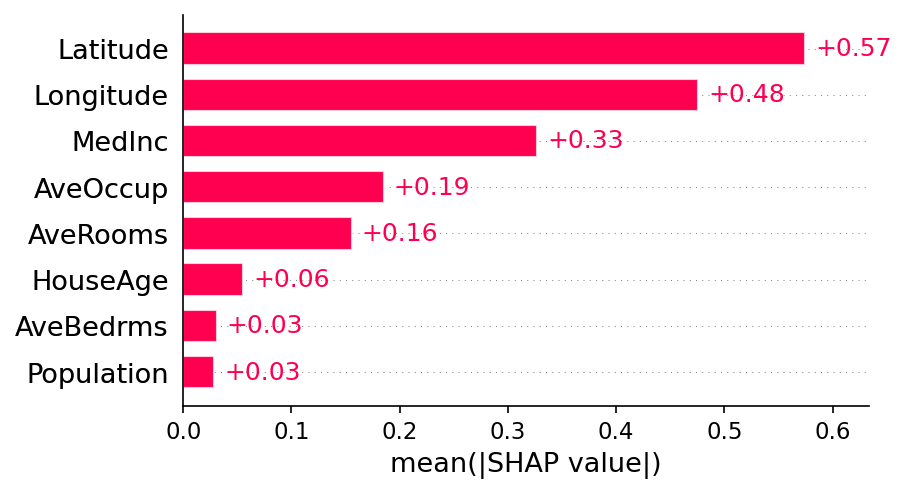

In [ ]:
fig, ax = plt.subplots(figsize=(5.9, 3.39), dpi=150)
shap.plots.bar(shap_values1, max_display=99, show=False, ax=ax)
plt.show()

#### Dependence Plots

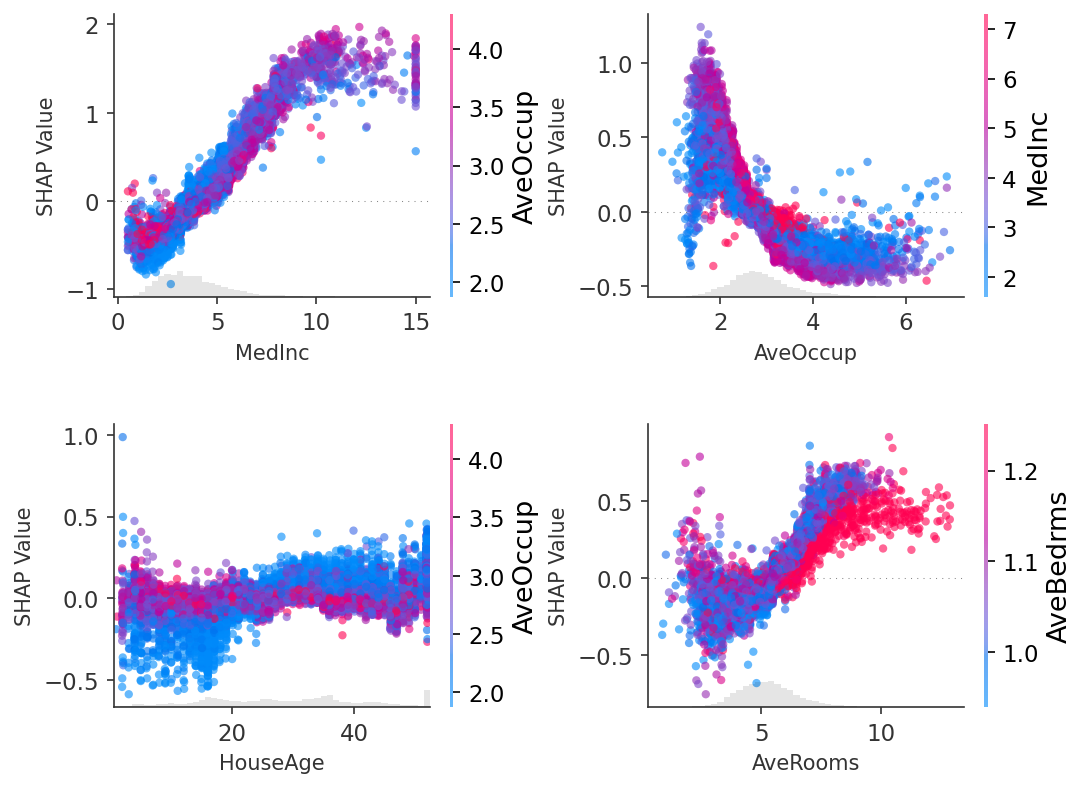

In [ ]:
def plot_shap_scatter(shap_values, feature_positions, fig_size=(8, 6)):
    masv = {feature: np.mean(np.abs(shap_values[:, feature].values)) for feature in shap_values.feature_names}

    fig, axarr = plt.subplots(2, 2, figsize=fig_size, dpi=150)
    plt.subplots_adjust(wspace=0.35, hspace=0.45)

    for feature, (i, j) in feature_positions.items():
        if feature in masv:
            shap_plot = shap.plots.scatter(shap_values[:, feature], ax=axarr[i, j], show=False, alpha=0.6, color=shap_values)

            axarr[i, j].grid(False, axis="y")
            axarr[i, j].set_ylabel("SHAP Value", fontsize=10)
            axarr[i, j].set_xlabel(feature, fontsize=10)

            if hasattr(shap_plot, 'colorbar'):
                shap_plot.colorbar.remove()
            axarr[i, j].title.set_visible(False)

    plt.show()


feature_positions = {
    'MedInc': (0, 0),
    'AveOccup': (0, 1),
    'HouseAge': (1, 0),
    'AveRooms': (1, 1)
}


explainer = shap.Explainer(bm_ch)
cleaned_X1 = X1[(X1['AveOccup'] <= 7) & (X1['AveRooms'] <= 13)]
clean_shap = explainer(cleaned_X1)
plot_shap_scatter(clean_shap, feature_positions)

#### Beeswarm Plot

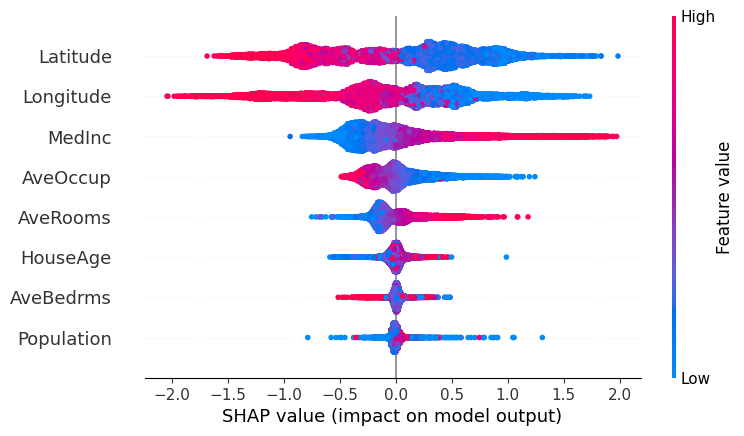

In [ ]:
shap.plots.beeswarm(shap_values1, max_display=99, show=True)

#### Discussion

&nbsp;&nbsp;&nbsp;&nbsp; The **Global Bar Plot**, similar to the earlier Relative Importance plot, presents the global importance of each feature, calculated as the mean absolute SHAP value across all observations for that feature. In this visualization, Latitude and Longitude are the most influential predictors, surpassing Median Income (MedInc), which contrasts with their earlier rankings.



&nbsp;&nbsp;&nbsp;&nbsp; The **SHAP Partial Dependence plot**  shows the relationship between specific features and the model’s predictions. One notable observation is a plateau effect for the House Age. The feature seems to have minimal explanatory power, as instances with the largest feature values span all house age ranges and typically register a SHAP value close to zero. This ambiguity likely contributes to its lower ranking on the predictor importance scale.



&nbsp;&nbsp;&nbsp;&nbsp; The **Beeswarm plot** shows us how features in a dataset influence the model's predictions and each dot within that row represents a data point. The aggregation of dots indicates density, the x-axis reflects the extent of positive or negative impact on model output, and the color signifies the feature's magnitude relative to others.

&nbsp;&nbsp;&nbsp;&nbsp; Notably, the plot reveals that lower Median Income negatively impacts house values; this is evident as the right side of the Median Income row is predominantly red, suggesting higher incomes boost predicted values. It also highlights a concentration of instances where lower Median Incomes appear to give minimal influence on predictions.

&nbsp;&nbsp;&nbsp;&nbsp; Furthermore, the plot reveals that a higher number of Average Rooms generally increases a home's value. This is highlighted by the abundance of red dots on the right, which indicate that greater room counts positively influence the model's predictions. Conversely, on the left side, there is a large cluster of blue dots demonstrating that fewer rooms correspond to a lower impact, with these data points mainly registering a SHAP value around -0.25. This suggests that a minimal number of rooms does not significantly contribute to the model's output



## Breast Cancer Wisconsin Dataset

### Load Dataset

In [ ]:
# Loading Dataset
bc = load_breast_cancer(as_frame=True)
X2, y2 = bc.data, bc.target

print(f"X Shape: {X2.shape}")
print(f"y Shape: {y2.shape}")
print("Features:", list(X2.columns))

# Data Split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=13)

X Shape: (569, 30)
y Shape: (569,)
Features: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


### Model

In [ ]:
model = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=1)

# Perform grid search
gs2 = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
gs2.fit(X2_train, y2_train)

bp_bc = gs2.best_params_
bs_bc = gs2.best_score_

print(f"Best score: {-bs_bc:.3f} (MSE)")
print(f"Best parameters: {bp_bc}")

Best score: 0.032 (MSE)
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 1500, 'subsample': 0.8}


### Training and Test Absolute Error

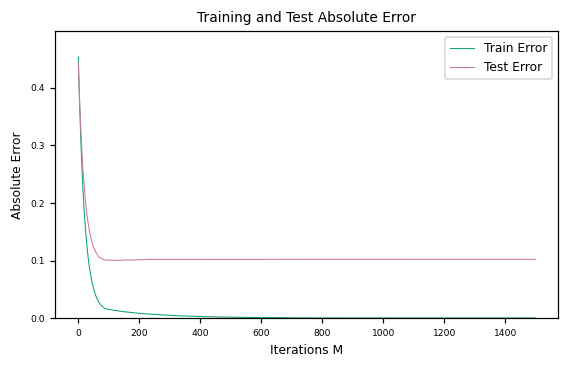

In [ ]:
bm_bc = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=1,
    colsample_bytree=bp_bc['colsample_bytree'],
    learning_rate=bp_bc['learning_rate'],
    max_depth=bp_bc['max_depth'],
    n_estimators=bp_bc['n_estimators'],
    subsample=bp_bc['subsample'],
    eval_metric='mae'
)

eval_set2 = [(X2_train, y2_train), (X2_test, y2_test)]
bm_bc.fit(X2_train, y2_train, eval_set=eval_set2, verbose=False)

results2 = bm_bc.evals_result()
train_error2 = results2['validation_0']['mae']
test_error2 = results2['validation_1']['mae']

plot_loss_graph(train_error2, test_error2)

### Relative Importance of Predictors

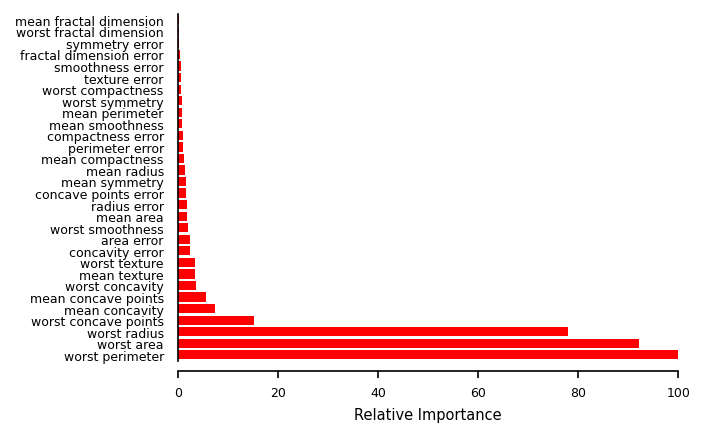

In [ ]:
plot_feature_importances(bm_bc, X2_train)

### Partial Dependance

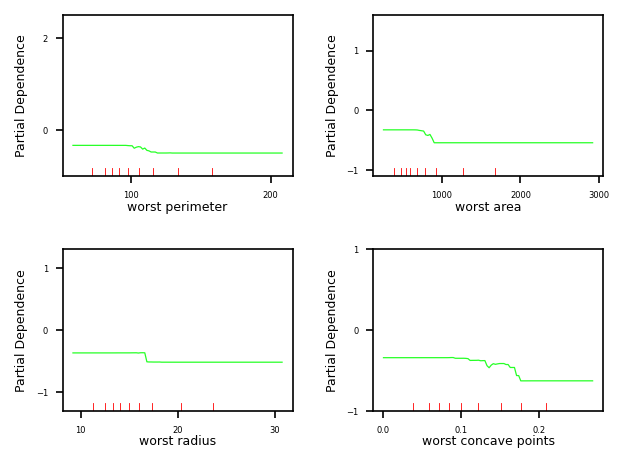

In [ ]:
fig, axarr = plt.subplots(2, 2, figsize=(4.65, 3.43), dpi=150)
plt.subplots_adjust(wspace=0.35, hspace=0.45)

plot_partial_dependence(bm_bc, X2, y2, 'worst perimeter', axarr[0, 0], (-1, 2.5))
plot_partial_dependence(bm_bc, X2, y2, 'worst area', axarr[0, 1], (-1.1, 1.6))
plot_partial_dependence(bm_bc, X2, y2, 'worst radius', axarr[1, 0], (-1.3, 1.3))
plot_partial_dependence(bm_bc, X2, y2, 'worst concave points', axarr[1, 1], (-1, 1))

plt.show()

### Two Variable Partial Dependence

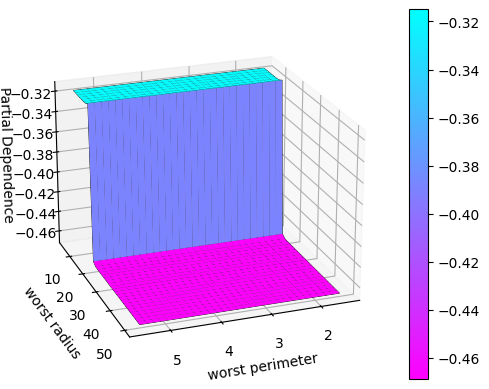

In [ ]:
plot_two_variable_partial_dependence(bm_bc, X2, y2, 'worst perimeter', 'worst radius')

### SHAP

In [ ]:
explainer2 = shap.Explainer(bm_bc)
shap_values2 = explainer2(X2)

#### Global Bar Plot

<Axes: xlabel='mean(|SHAP value|)'>

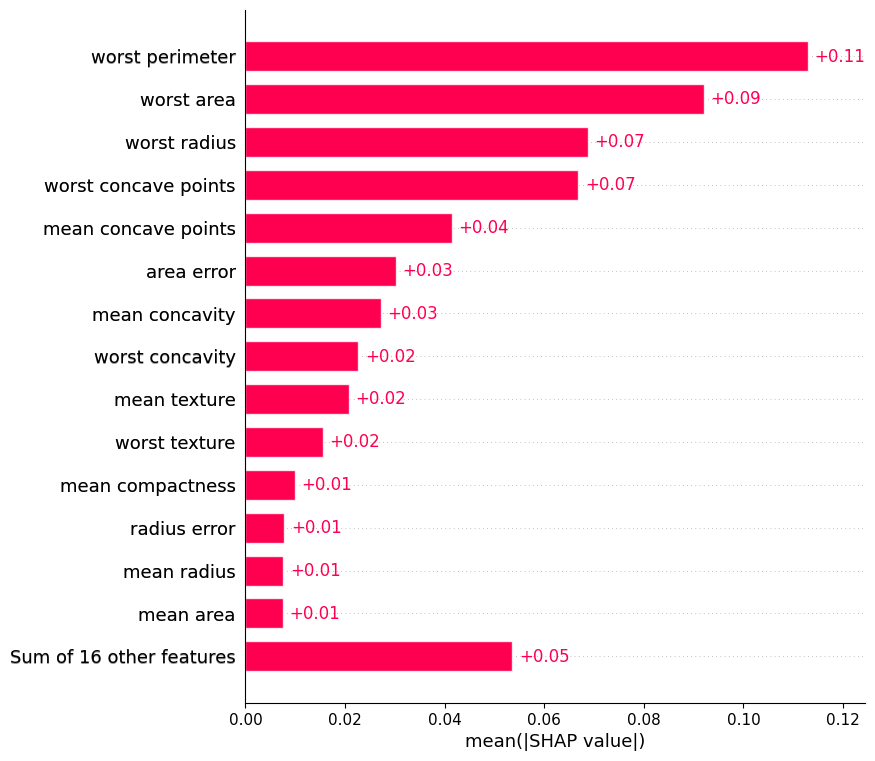

In [ ]:
shap.plots.bar(shap_values2, max_display=15, show=False)

#### Partial Dependence Plots

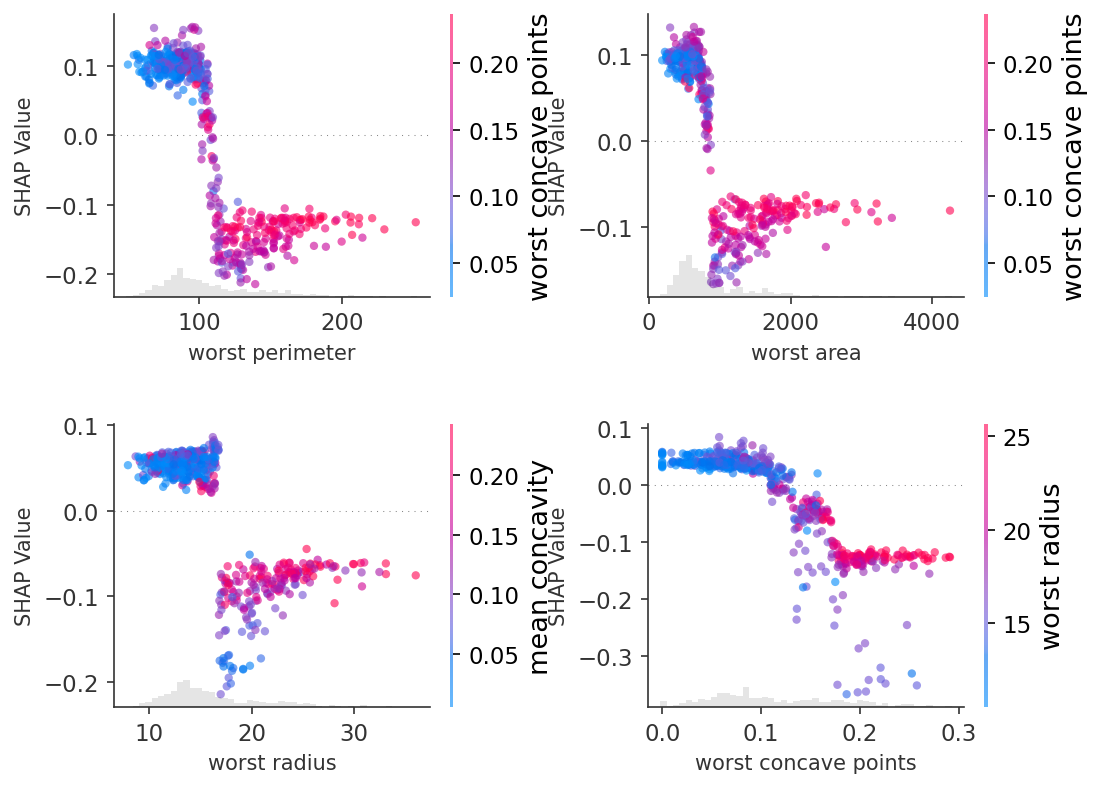

In [ ]:
feature_positions2 = {
    'worst perimeter': (0, 0),
    'worst area': (0, 1),
    'worst radius': (1, 0),
    'worst concave points': (1, 1)
}

plot_shap_scatter(shap_values2, feature_positions2)

#### Beeswarm Plot

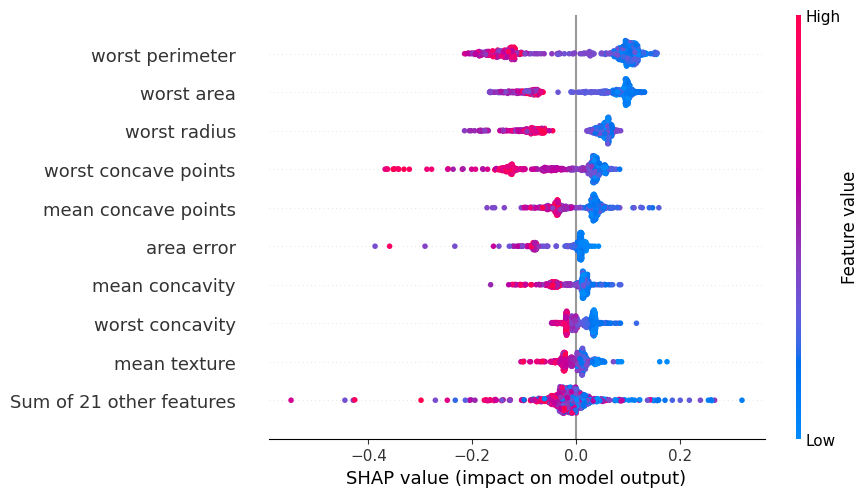

In [ ]:
shap.plots.beeswarm(shap_values2, max_display=10, show=True)